In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import pandas as pd
from chainconsumer import ChainConsumer
from sbi_lens.config import config_lsst_y_10

In [ ]:
import arviz as az
az.style.use("arviz-white")


In [ ]:
# plot params

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["lines.linewidth"] = 1
plt.rcParams['lines.markersize'] = 3
color = [
   '#f8c471',
    '#d68910',
    '#cd6155',
    '#edbb99',
    '#5d6d7e',
    '#73c6b6',
    '#a3b899'
]

In [ ]:
from sbi_lens.config import config_lsst_y_10

params_name = config_lsst_y_10.params_name_latex
truth = config_lsst_y_10.truth

In [49]:
sample_ff = jnp.load(
    "/linkhome/rech/genkqu01/ufa23yn/sbi_lens/sbi_lens/data/posterior_full_field__256N_10ms_27gpa_0.26se.npy"
)
# inds = np.random.randint(0, len(sample_ff), 100_000)
# sample_ff = sample_ff[inds]
mean_truth = jnp.mean(sample_ff, axis = 0)
std_truth = jnp.std(sample_ff, axis = 0)

In [50]:
plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams['lines.markersize'] = 7
colmap=['#cd6155', '#5d6d7e', '#a3b899']

total_steps = 70_000
n_flow_layers = 4
n_bijector_layers = 2
activ_fun = 'silu'
proposal = 'prior'
sbi_method  = 'nle'
lr_schedule = 'exp_decay'
nf = 'affine'
bacth_size = 128
seed=3


info_setup = [
    ['unmarginal', 0.0, 0.0]
]

metric_mean = {}
metric_std = {}
sim = {}
for info in info_setup:

    score, score_noise, score_weight = info

    posterior_mean_mean_store = []
    posterior_mean_std_store = []
    posterior_std_mean_store = []
    posterior_std_std_store = []

    for nb_simulations_allow in [100,200,300,400,600,800,1000,1500,2000]:
        
        posterior_mean = []
        posterior_std = []
        count = 0
        for seed in [1,2,3,4,5,6, 111]:
            exp_id = "exp_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
                sbi_method,
                total_steps,
                nb_simulations_allow,
                seed,
                n_flow_layers,
                n_bijector_layers,
                activ_fun,
                nf,
                bacth_size,
                score_weight,
                score,
                score_noise,
            )
            posterior = np.load('../results/experiments/{}/posteriors_sample.npy'.format(exp_id))
            if posterior.size != 0:
                count +=1
                # print(posterior[:100_000].shape)
                posterior_mean.append(jnp.mean(posterior, axis =0))
                posterior_std.append(jnp.std(posterior, axis = 0))
        # print(count)
        posterior_mean_mean_store.append(jnp.mean(jnp.array(posterior_mean), axis = 0))
        posterior_mean_std_store.append(jnp.std(jnp.array(posterior_mean), axis = 0))
        posterior_std_mean_store.append(jnp.mean(jnp.array(posterior_std), axis = 0))
        posterior_std_std_store.append(jnp.std(jnp.array(posterior_std), axis = 0))

/tmp/ipykernel_2849030/589689045.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust layout to prevent overlap


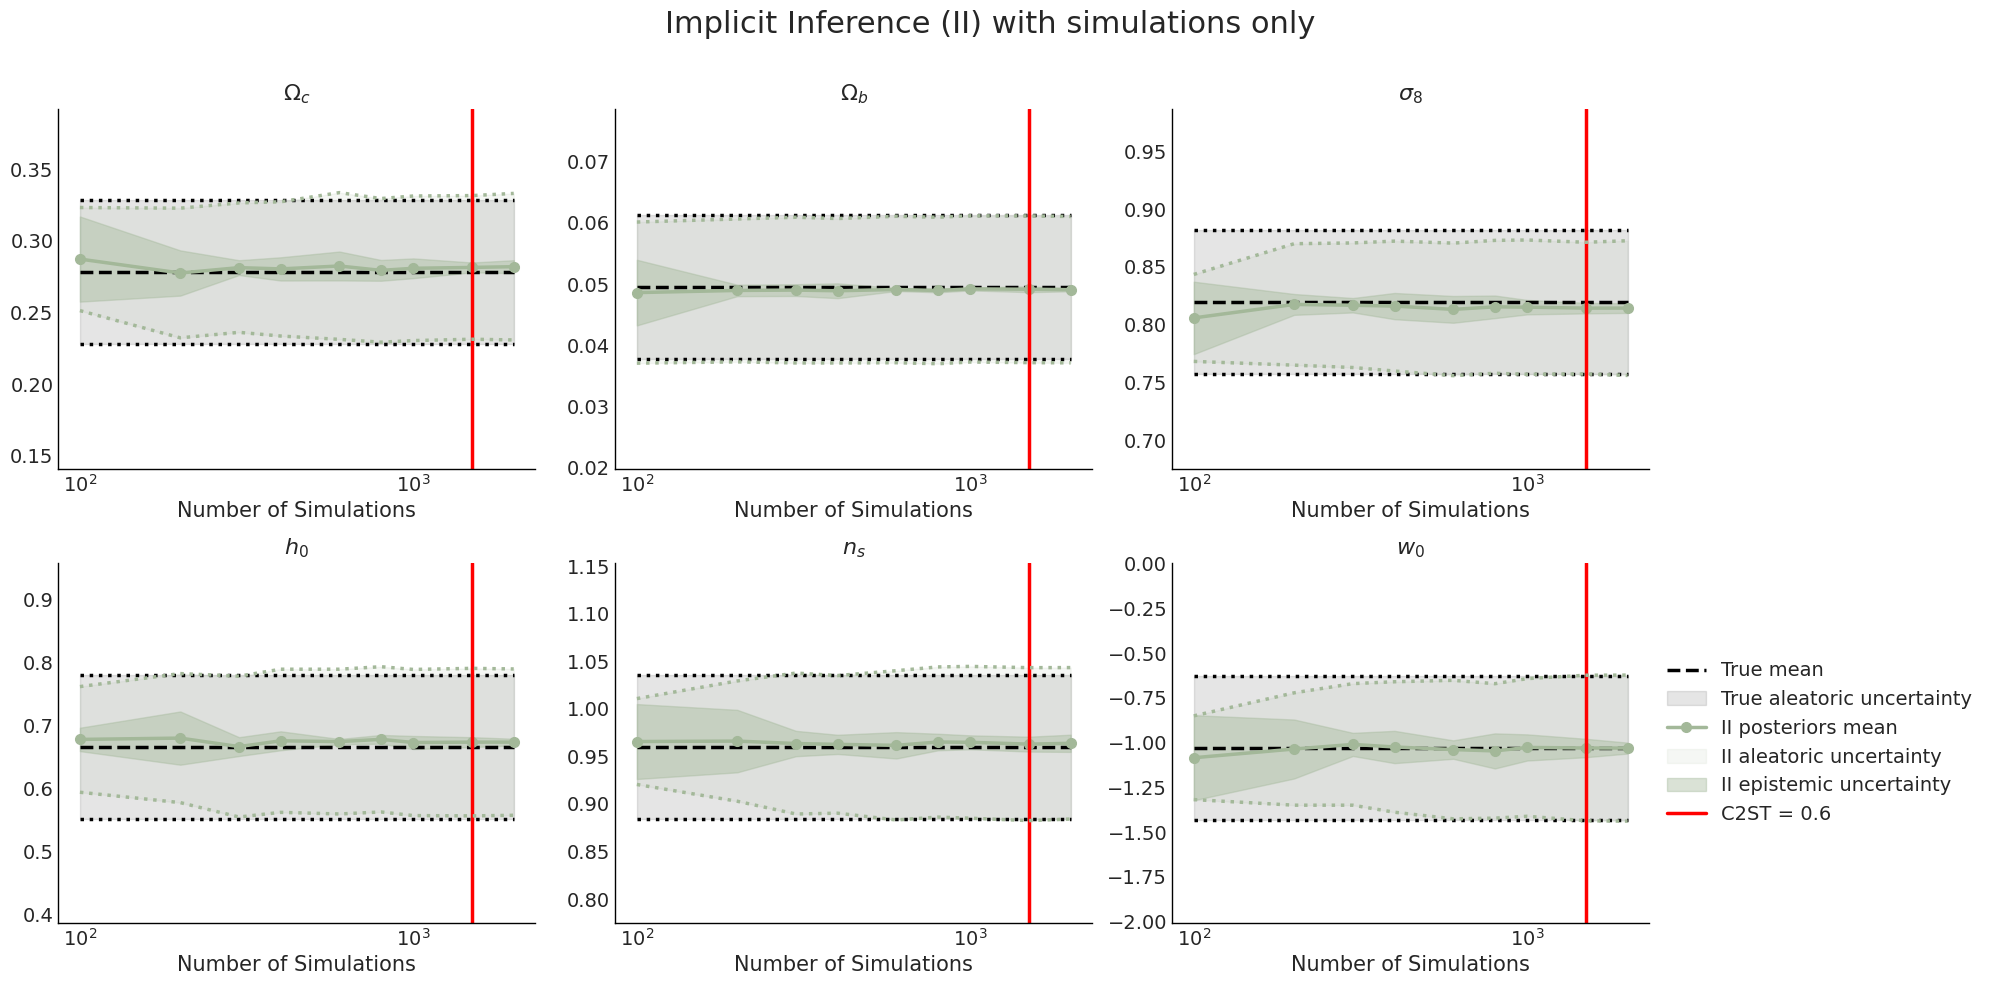

In [51]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))  # Adjusted figsize to accommodate two rows
simu_budget = jnp.array([100,200,300,400,600,800,1000,1500,2000])
 # List to store legend labels
t = 2
for i in range(6):
    legend_labels = []
    plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns
    plt.plot(simu_budget, np.array(mean_truth)[i] * jnp.ones(len(simu_budget)), '--', color='black')
    plt.fill_between(
        simu_budget,
        np.array(mean_truth)[i] * jnp.ones(len(simu_budget)) - t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), 
        np.array(mean_truth)[i] * jnp.ones(len(simu_budget)) + t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), 
        alpha=0.1, 
        color='black'
    )
    plt.plot(simu_budget, np.array(posterior_mean_mean_store)[:, i], color=color[6], marker='o')
    plt.fill_between(
        simu_budget,
        np.array(posterior_mean_mean_store)[:,i] - t*np.array(posterior_std_mean_store)[:,i], 
        np.array(posterior_mean_mean_store)[:,i] + t*np.array(posterior_std_mean_store)[:,i], 
        alpha=0.1, 
        color=color[6]
    )
    plt.fill_between(
        simu_budget,
        np.array(posterior_mean_mean_store)[:,i] - t*np.array(posterior_mean_std_store)[:,i], 
        np.array(posterior_mean_mean_store)[:,i] + t*np.array(posterior_mean_std_store)[:,i], 
        alpha=0.4, 
        color=color[6]
    )
    plt.axvline(x=1500, color='red')
    plt.plot(simu_budget, jnp.array(mean_truth)[i] * jnp.ones(len(simu_budget)) - t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), ':', color='black')
    plt.plot(simu_budget, jnp.array(mean_truth)[i] * jnp.ones(len(simu_budget)) + t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), ':', color='black')
    plt.plot(simu_budget, np.array(posterior_mean_mean_store)[:,i] - t*np.array(posterior_std_mean_store)[:,i], ':', color=color[6])
    plt.plot(simu_budget, np.array(posterior_mean_mean_store)[:,i] + t*np.array(posterior_std_mean_store)[:,i], ':', color=color[6])
    # plt.errorbar(1000, np.array(posteior_mean_conv)[:,i], yerr=t*np.array(posterior_std_conv)[:,i], fmt="o", color=color[6], alpha=,.
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.ylim(truth[i] - 5 * np.std(sample_ff[:,i]), truth[i] + 5 * np.std(sample_ff[:,i])) 
    plt.xlabel('Number of Simulations')
    plt.title(params_name[i])  # Adding subplot title
    
    # Append labels to the legend_labels list
    legend_labels.append(f'True mean')
    legend_labels.append(f'True aleatoric uncertainty')
    legend_labels.append(f'II posteriors mean')
    legend_labels.append(f'II aleatoric uncertainty')
    legend_labels.append(f'II epistemic uncertainty')
    legend_labels.append(f'C2ST = 0.6')


# Plot a single legend on the right
plt.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle("Implicit Inference (II) with simulations only \n", size=22)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('mean_and_convergence_ii_unmarginal.pdf', transparent = True)

In [52]:
plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams['lines.markersize'] = 7
colmap=['#cd6155', '#5d6d7e', '#a3b899']

total_steps = 70_000
n_flow_layers = 4
n_bijector_layers = 2
activ_fun = 'silu'
proposal = 'prior'
sbi_method  = 'nle'
lr_schedule = 'exp_decay'
nf = 'affine'
bacth_size = 128
seed=3


info_setup = [
    ['unmarginal', 0.0, 1e-5]
]

metric_mean = {}
metric_std = {}
sim = {}
for info in info_setup:

    score, score_noise, score_weight = info

    posterior_mean_mean_store = []
    posterior_mean_std_store = []
    posterior_std_mean_store = []
    posterior_std_std_store = []

    for nb_simulations_allow in [100,200,300,400,600,800,1000,1500,2000]:
        
        posterior_mean = []
        posterior_std = []
        count = 0
        for seed in [1,2,3,4,5,6, 111]:
            exp_id = "exp_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
                sbi_method,
                total_steps,
                nb_simulations_allow,
                seed,
                n_flow_layers,
                n_bijector_layers,
                activ_fun,
                nf,
                bacth_size,
                score_weight,
                score,
                score_noise,
            )
            posterior = np.load('../results/experiments/{}/posteriors_sample.npy'.format(exp_id))
            if posterior.size != 0:
                count +=1
                # print(posterior[:100_000].shape)
                posterior_mean.append(jnp.mean(posterior, axis =0))
                posterior_std.append(jnp.std(posterior, axis = 0))
        # print(count)
        posterior_mean_mean_store.append(jnp.mean(jnp.array(posterior_mean), axis = 0))
        posterior_mean_std_store.append(jnp.std(jnp.array(posterior_mean), axis = 0))
        posterior_std_mean_store.append(jnp.mean(jnp.array(posterior_std), axis = 0))
        posterior_std_std_store.append(jnp.std(jnp.array(posterior_std), axis = 0))

/tmp/ipykernel_2849030/3914229596.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust layout to prevent overlap


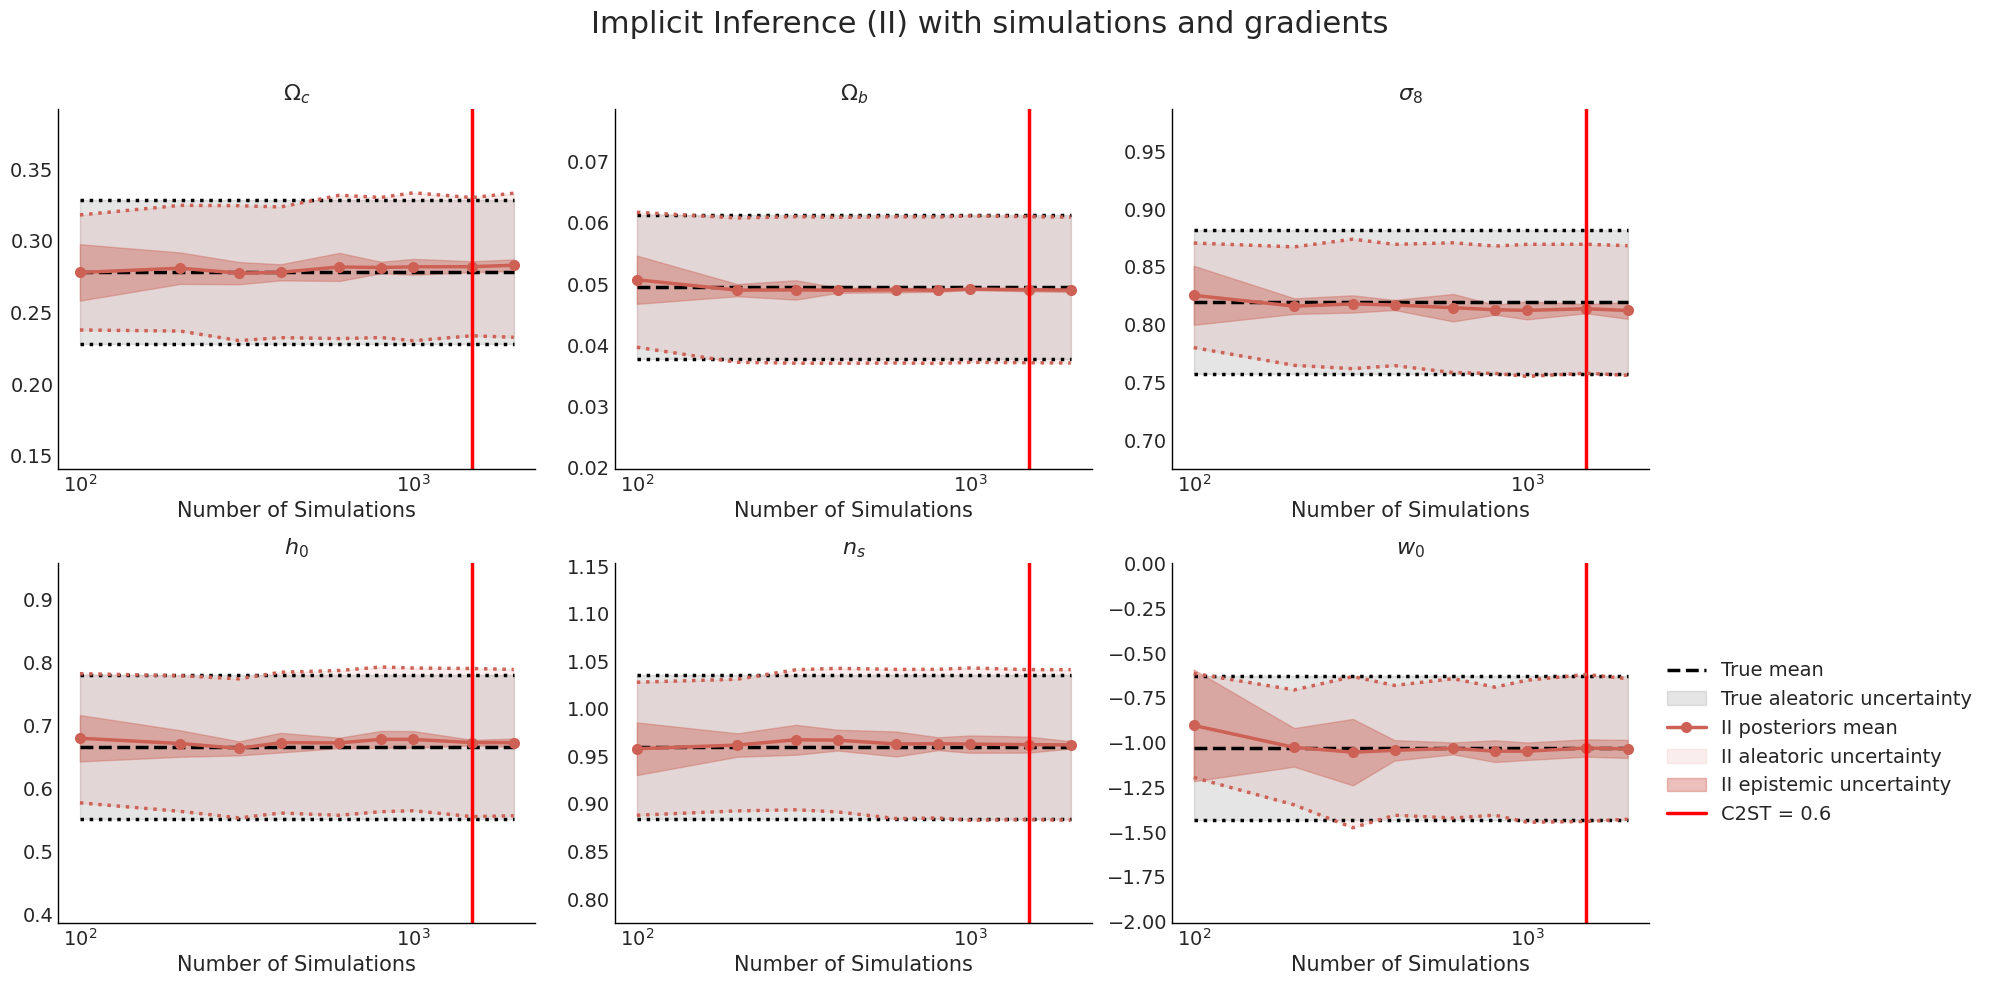

In [53]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))  # Adjusted figsize to accommodate two rows
simu_budget = jnp.array([100,200,300,400,600,800,1000,1500,2000])
 # List to store legend labels
t = 2
for i in range(6):
    legend_labels = []
    plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns
    plt.plot(simu_budget, np.array(mean_truth)[i] * jnp.ones(len(simu_budget)), '--', color='black')
    plt.fill_between(
        simu_budget,
        np.array(mean_truth)[i] * jnp.ones(len(simu_budget)) - t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), 
        np.array(mean_truth)[i] * jnp.ones(len(simu_budget)) + t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), 
        alpha=0.1, 
        color='black'
    )
    plt.plot(simu_budget, np.array(posterior_mean_mean_store)[:, i], color=color[2], marker='o')
    plt.fill_between(
        simu_budget,
        np.array(posterior_mean_mean_store)[:,i] - t*np.array(posterior_std_mean_store)[:,i], 
        np.array(posterior_mean_mean_store)[:,i] + t*np.array(posterior_std_mean_store)[:,i], 
        alpha=0.1, 
        color=color[2]
    )
    plt.fill_between(
        simu_budget,
        np.array(posterior_mean_mean_store)[:,i] - t*np.array(posterior_mean_std_store)[:,i], 
        np.array(posterior_mean_mean_store)[:,i] + t*np.array(posterior_mean_std_store)[:,i], 
        alpha=0.4, 
        color=color[2]
    )
    plt.axvline(x=1500, color='red')
    plt.plot(simu_budget, jnp.array(mean_truth)[i] * jnp.ones(len(simu_budget)) - t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), ':', color='black')
    plt.plot(simu_budget, jnp.array(mean_truth)[i] * jnp.ones(len(simu_budget)) + t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), ':', color='black')
    plt.plot(simu_budget, np.array(posterior_mean_mean_store)[:,i] - t*np.array(posterior_std_mean_store)[:,i], ':', color=color[2])
    plt.plot(simu_budget, np.array(posterior_mean_mean_store)[:,i] + t*np.array(posterior_std_mean_store)[:,i], ':', color=color[2])
    # plt.errorbar(1000, np.array(posteior_mean_conv)[:,i], yerr=t*np.array(posterior_std_conv)[:,i], fmt="o", color=color[6], alpha=,.
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.ylim(truth[i] - 5 * np.std(sample_ff[:,i]), truth[i] + 5 * np.std(sample_ff[:,i])) 
    plt.xlabel('Number of Simulations')
    plt.title(params_name[i])  # Adding subplot title
    
    # Append labels to the legend_labels list
    legend_labels.append(f'True mean')
    legend_labels.append(f'True aleatoric uncertainty')
    legend_labels.append(f'II posteriors mean')
    legend_labels.append(f'II aleatoric uncertainty')
    legend_labels.append(f'II epistemic uncertainty')
    legend_labels.append(f'C2ST = 0.6')


# Plot a single legend on the right
plt.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle("Implicit Inference (II) with simulations and gradients \n", size=22)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('mean_and_convergence_ii_gradients.pdf', transparent = True)

In [54]:
plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams['lines.markersize'] = 7
colmap=['#cd6155', '#5d6d7e', '#a3b899']

total_steps = 70_000
n_flow_layers = 4
n_bijector_layers = 2
activ_fun = 'silu'
proposal = 'prior'
sbi_method  = 'nle'
lr_schedule = 'exp_decay'
nf = 'affine'
bacth_size = 128
seed=3


info_setup = [
    ['marginal', 0.0, 1e-5]
]

metric_mean = {}
metric_std = {}
sim = {}
for info in info_setup:

    score, score_noise, score_weight = info

    posterior_mean_mean_store = []
    posterior_mean_std_store = []
    posterior_std_mean_store = []
    posterior_std_std_store = []

    for nb_simulations_allow in [100,200,300,400,600,800,1000,1500,2000]:
        
        posterior_mean = []
        posterior_std = []
        count = 0
        for seed in [1,2,3,4,5,6]:
            exp_id = "exp_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
                sbi_method,
                total_steps,
                nb_simulations_allow,
                seed,
                n_flow_layers,
                n_bijector_layers,
                activ_fun,
                nf,
                bacth_size,
                score_weight,
                score,
                score_noise,
            )
            posterior = np.load('../results/experiments/{}/posteriors_sample.npy'.format(exp_id))
            if posterior.size != 0:
                count +=1
                # print(posterior[:100_000].shape)
                posterior_mean.append(jnp.mean(posterior, axis =0))
                posterior_std.append(jnp.std(posterior, axis = 0))
        # print(count)
        posterior_mean_mean_store.append(jnp.mean(jnp.array(posterior_mean), axis = 0))
        posterior_mean_std_store.append(jnp.std(jnp.array(posterior_mean), axis = 0))
        posterior_std_mean_store.append(jnp.mean(jnp.array(posterior_std), axis = 0))
        posterior_std_std_store.append(jnp.std(jnp.array(posterior_std), axis = 0))

/tmp/ipykernel_2849030/2418923337.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust layout to prevent overlap


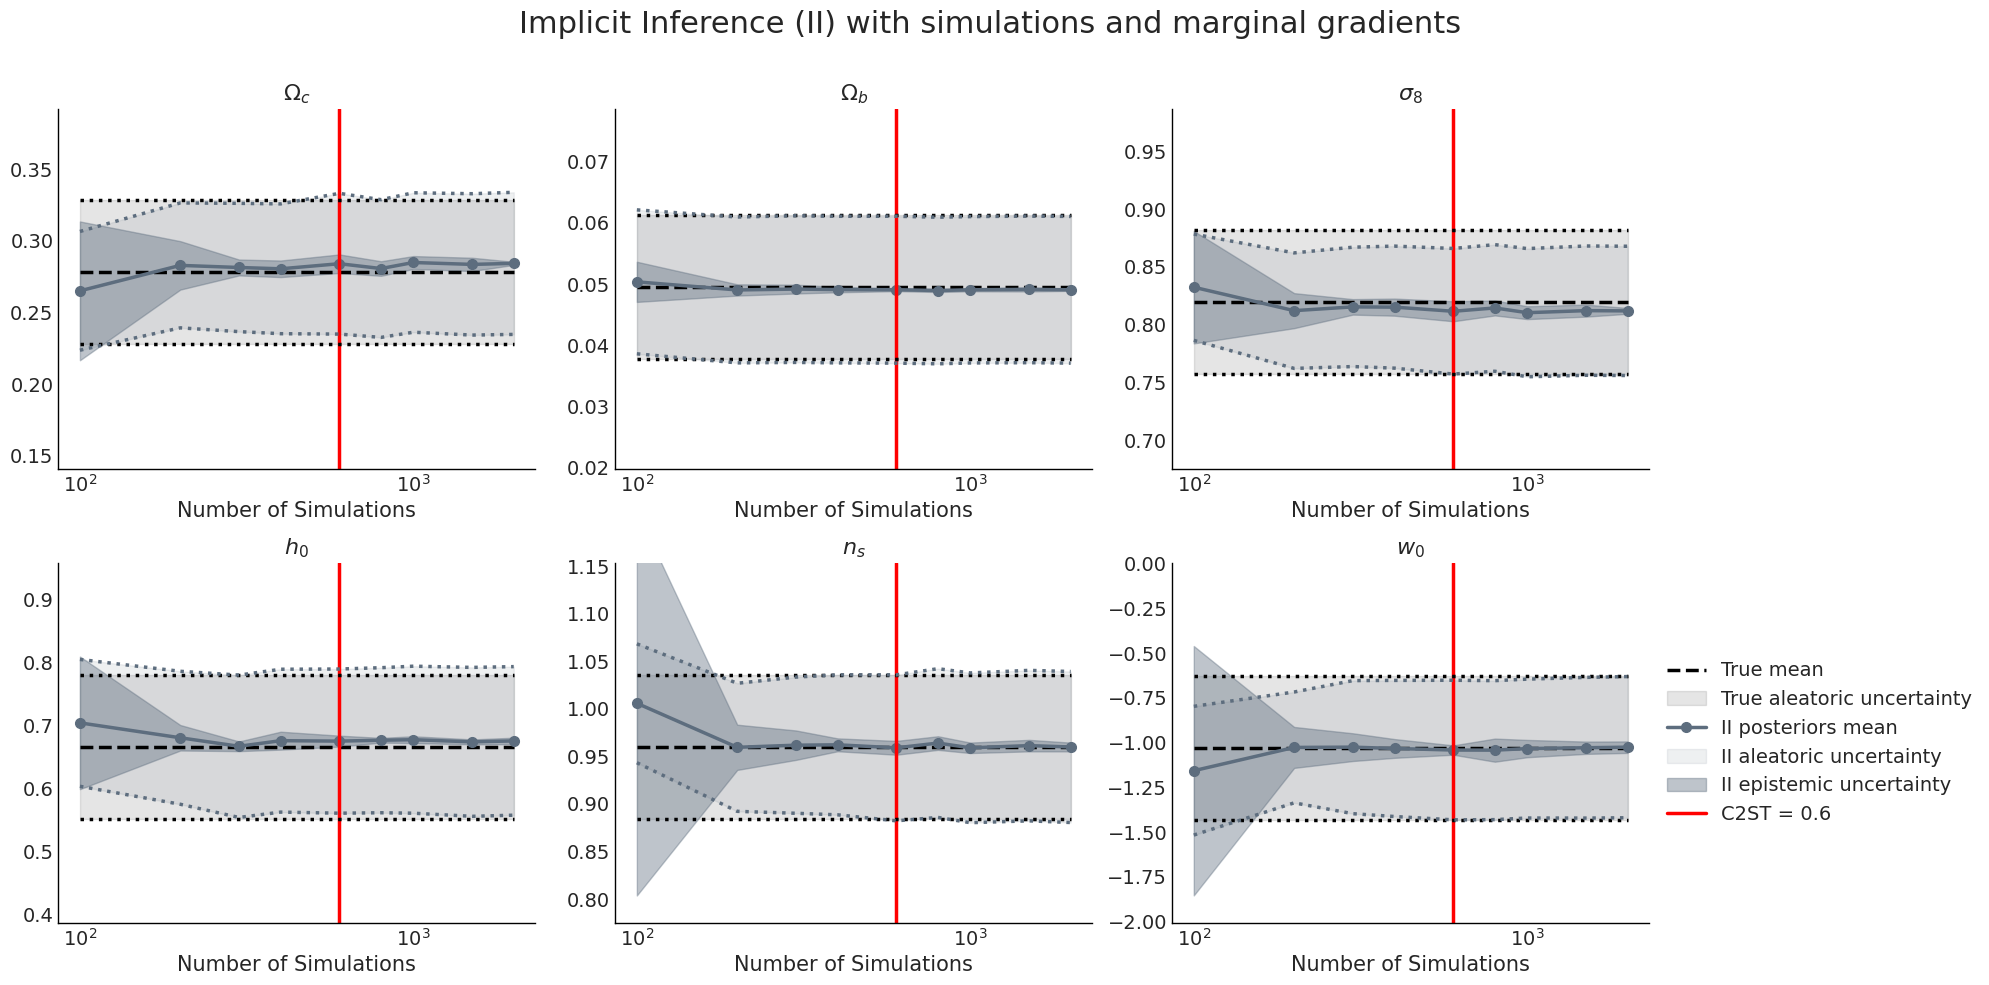

In [55]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))  # Adjusted figsize to accommodate two rows
simu_budget = jnp.array([100,200,300,400,600,800,1000,1500,2000])
 # List to store legend labels
t = 2
for i in range(6):
    legend_labels = []
    plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns
    plt.plot(simu_budget, np.array(mean_truth)[i] * jnp.ones(len(simu_budget)), '--', color='black')
    plt.fill_between(
        simu_budget,
        np.array(mean_truth)[i] * jnp.ones(len(simu_budget)) - t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), 
        np.array(mean_truth)[i] * jnp.ones(len(simu_budget)) + t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), 
        alpha=0.1, 
        color='black'
    )
    plt.plot(simu_budget, np.array(posterior_mean_mean_store)[:, i], color=color[4], marker='o')
    plt.fill_between(
        simu_budget,
        np.array(posterior_mean_mean_store)[:,i] - t*np.array(posterior_std_mean_store)[:,i], 
        np.array(posterior_mean_mean_store)[:,i] + t*np.array(posterior_std_mean_store)[:,i], 
        alpha=0.1, 
        color=color[4]
    )
    plt.fill_between(
        simu_budget,
        np.array(posterior_mean_mean_store)[:,i] - t*np.array(posterior_mean_std_store)[:,i], 
        np.array(posterior_mean_mean_store)[:,i] + t*np.array(posterior_mean_std_store)[:,i], 
        alpha=0.4, 
        color=color[4]
    )
    plt.axvline(x=600, color='red')
    plt.plot(simu_budget, jnp.array(mean_truth)[i] * jnp.ones(len(simu_budget)) - t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), ':', color='black')
    plt.plot(simu_budget, jnp.array(mean_truth)[i] * jnp.ones(len(simu_budget)) + t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), ':', color='black')
    plt.plot(simu_budget, np.array(posterior_mean_mean_store)[:,i] - t*np.array(posterior_std_mean_store)[:,i], ':', color=color[4])
    plt.plot(simu_budget, np.array(posterior_mean_mean_store)[:,i] + t*np.array(posterior_std_mean_store)[:,i], ':', color=color[4])
    # plt.errorbar(1000, np.array(posteior_mean_conv)[:,i], yerr=t*np.array(posterior_std_conv)[:,i], fmt="o", color=color[6], alpha=,.
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.ylim(truth[i] - 5 * np.std(sample_ff[:,i]), truth[i] + 5 * np.std(sample_ff[:,i])) 
    plt.xlabel('Number of Simulations')
    plt.title(params_name[i])  # Adding subplot title
    
    # Append labels to the legend_labels list
    legend_labels.append(f'True mean')
    legend_labels.append(f'True aleatoric uncertainty')
    legend_labels.append(f'II posteriors mean')
    legend_labels.append(f'II aleatoric uncertainty')
    legend_labels.append(f'II epistemic uncertainty')
    legend_labels.append(f'C2ST = 0.6')


# Plot a single legend on the right
plt.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle("Implicit Inference (II) with simulations and marginal gradients \n", size=22)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('mean_and_convergence_ii_marginal_gradients.pdf', transparent = True)

/tmp/ipykernel_2358213/2302511722.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust layout to prevent overlap


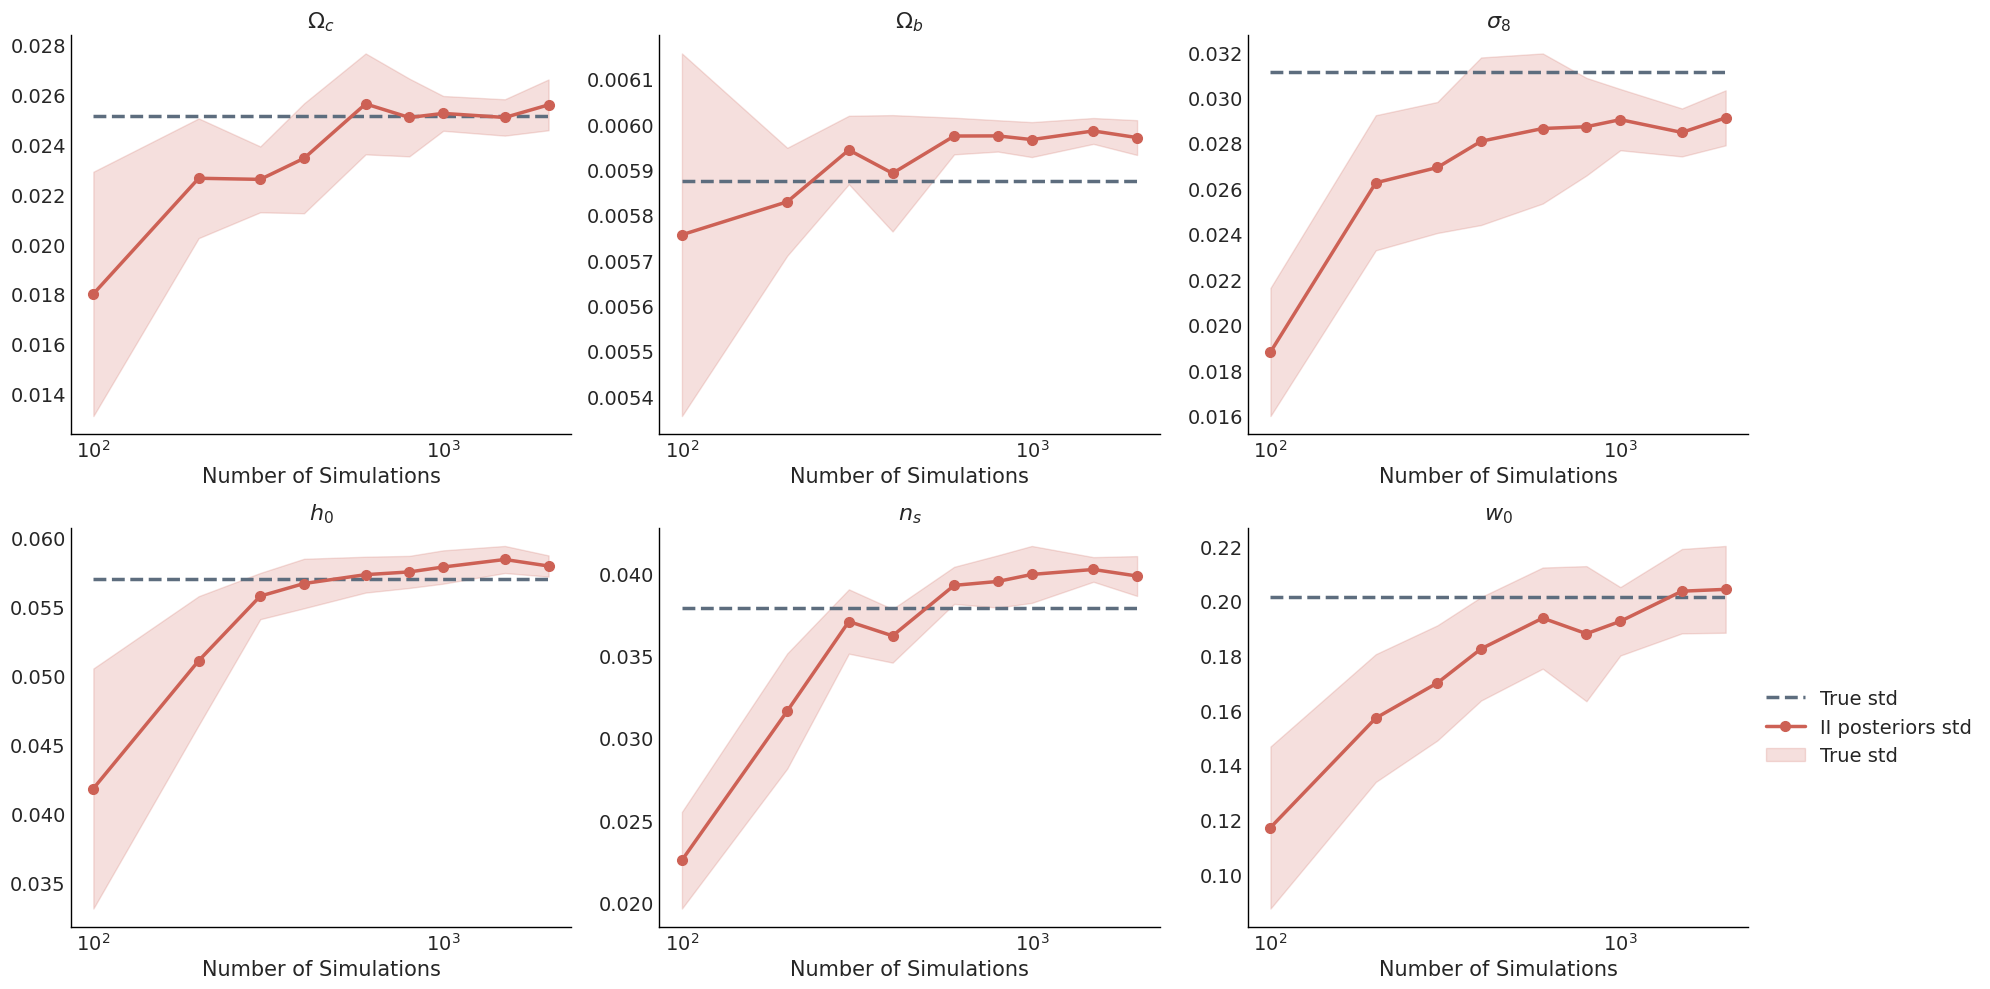

In [19]:
# import matplotlib.pyplot as plt
# import numpy as np

# plt.figure(figsize=(20, 10))  # Adjusted figsize to accommodate two rows
# simu_budget = jnp.array([100,200,300,400,600,800,1000,1500,2000])
# legend_labels = []  # List to store legend labels
# t = 1
# for i in range(6):
#     plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns
#     plt.plot(simu_budget, np.array(std_truth)[i] * jnp.ones(len(simu_budget)), '--', color=color[4], label='true mean')
#     # plt.fill_between(
#     #     simu_budget,
#     #     np.array(mean_truth)[i] * jnp.ones(len(simu_budget)) - t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), 
#     #     np.array(mean_truth)[i] * jnp.ones(len(simu_budget)) + t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), 
#     #     alpha=0.2, 
#     #     color=color[4]
#     # )
#     plt.plot(simu_budget, np.array(posterior_std_mean_store)[:, i], color=color[2], label='mean', marker='o')
#     plt.fill_between(
#         simu_budget,
#         np.array(posterior_std_mean_store)[:,i] - t*np.array(posterior_std_std_store)[:,i], 
#         np.array(posterior_std_mean_store)[:,i] + t*np.array(posterior_std_std_store)[:,i], 
#         alpha=0.2, 
#         color=color[2]
#     )
#     # plt.errorbar(1000, np.array(posteior_mean_conv)[:,i], yerr=t*np.array(posterior_std_conv)[:,i], fmt="o", color=color[6], alpha=1)
#     plt.xscale('log')  # Set x-axis to logarithmic scale
#     plt.xlabel('Number of Simulations')
#     plt.title(params_name[i])  # Adding subplot title
    
#     # Append labels to the legend_labels list
#     legend_labels.append(f'True std')
#     legend_labels.append(f'II posteriors std')

# # Plot a single legend on the right
# plt.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

# plt.tight_layout()  # Adjust layout to prevent overlap
# plt.savefig('std_and_convergence_ii.pdf', transparent = True)

In [66]:
import jax.numpy as jnp
from sklearn.neighbors import KernelDensity
import numpy as np
from chainconsumer import ChainConsumer
# from sbi_lens.config import config_lsst_y_10

In [67]:
number_chains = 31
chains = []
for i in range(number_chains):
    posterior = jnp.load(
    '/gpfsdswork/projects/rech/eqw/ufa23yn/dev/lensing_project/paper_sbi_lensing/hmc_becnhmarck/posterior_full_field_job_{}N_256ms_10gpa_27se.npy'.format(i),
    allow_pickle=True
    )
    chains.append(posterior)
    
chains = jnp.array(chains).reshape([-1,6])

In [81]:
simu_budget = jnp.array([200, 400, 600, 1000, 1500, 2000, 3000, 5000, 8_000])
# 100,200,300,400,600,800,1000,1500,2000])
mean_store = []
std_store = []
for i in simu_budget:
    X = chains[:i, :]
    # kde = KernelDensity(kernel='gaussian', bandwidth=1e-3).fit(X)
    # kde_sample = kde.sample(len(chains))
    mean_store.append(jnp.mean(X, axis = 0))
    std_store.append(jnp.std(X, axis = 0))

In [82]:
# inds = np.random.randint(0, len(chains), 10_000)
mean_truth = jnp.mean(sample_ff, axis = 0)
std_truth = jnp.std(sample_ff, axis = 0)

/tmp/ipykernel_2849030/408391043.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust layout to prevent overlap


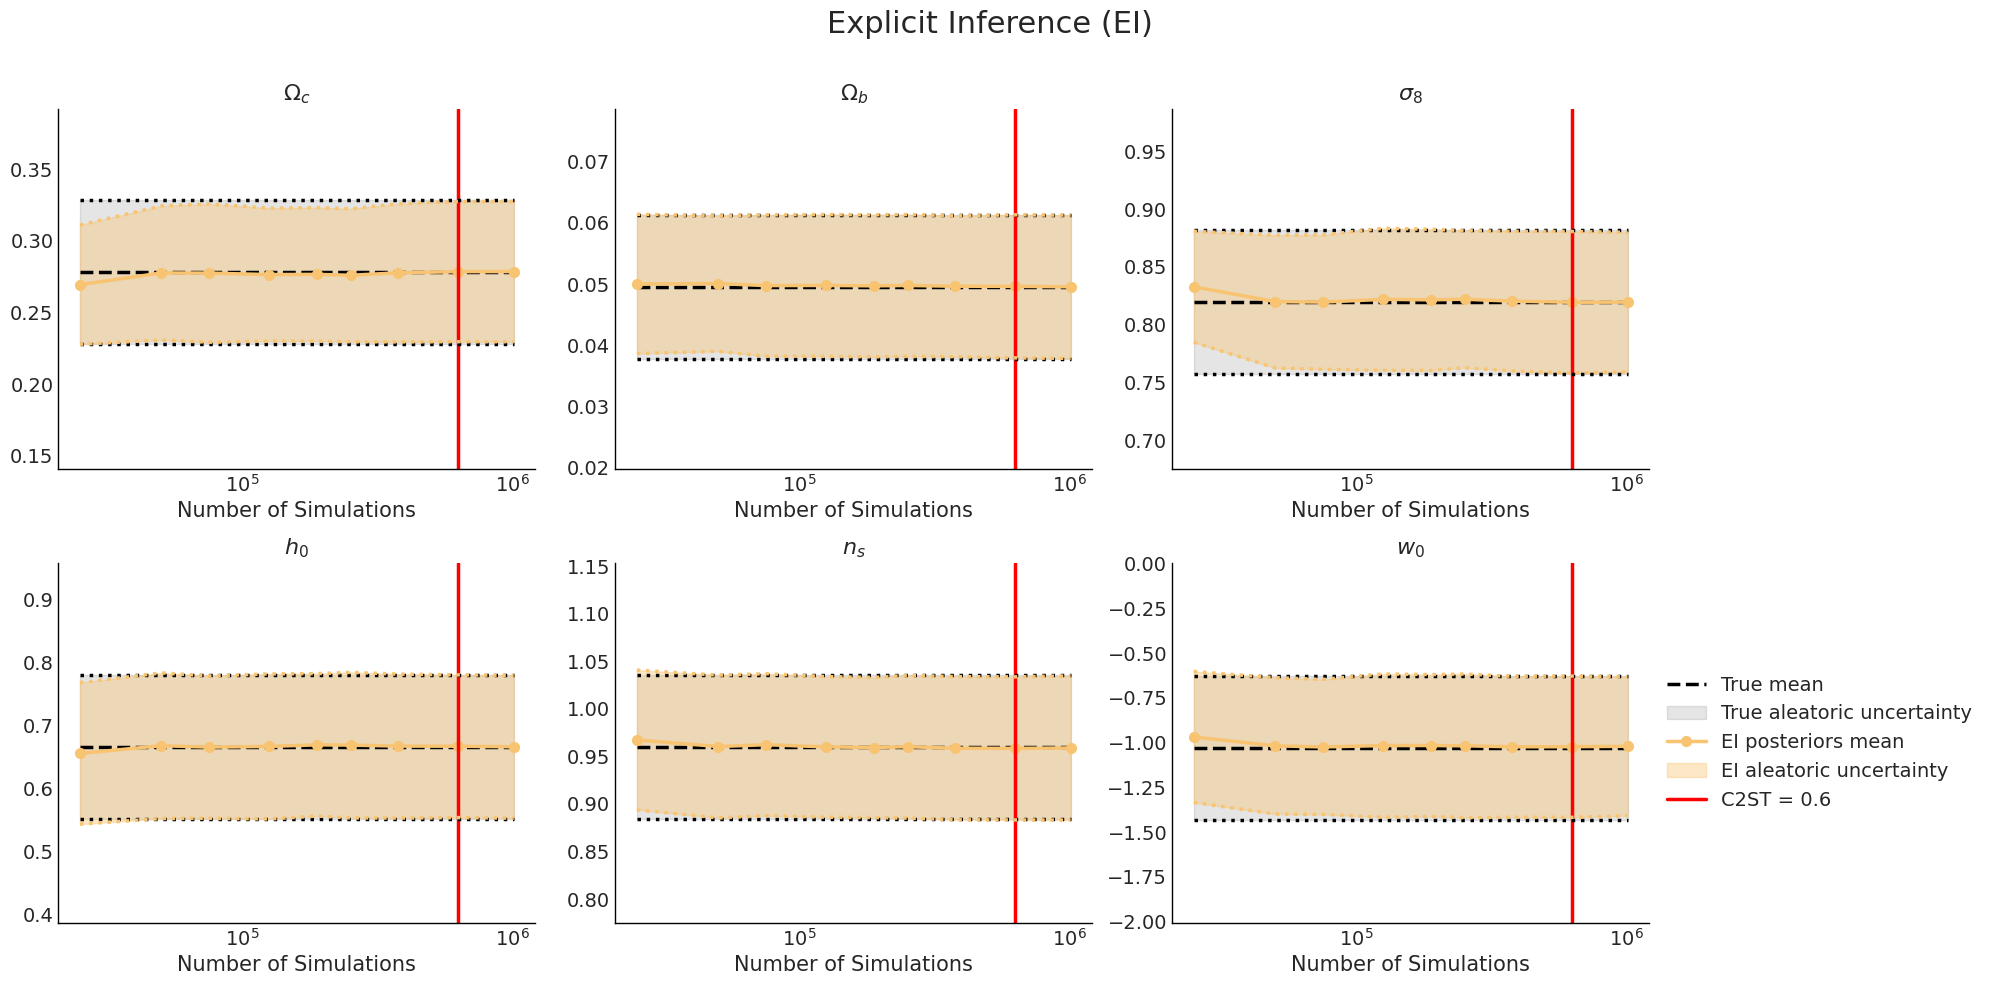

Exception ignored in atexit callback: <bound method InteractiveShell.atexit_operations of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x15069810a020>>
Traceback (most recent call last):
  File "/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3809, in atexit_operations
    self._atexit_once()
  File "/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3792, in _atexit_once
    self.history_manager.end_session()
  File "/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/IPython/core/history.py", line 576, in end_session
    self.writeout_cache()
  File "/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/decorator.py", line 232, in fun
    return caller(func, *(extras + args), **kw)
  File "/gp

In [83]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))  # Adjusted figsize to accommodate two rows
simu_budget = jnp.array([200, 400, 600, 1000, 1500, 2000, 3000, 5000, 8_000])*63*2
 # List to store legend labels
t = 2
for i in range(6):
    legend_labels = []
    plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns
    plt.plot(simu_budget, np.array(mean_truth)[i] * jnp.ones(len(simu_budget)), '--', color='black')
    plt.fill_between(
        simu_budget,
        np.array(mean_truth)[i] * jnp.ones(len(simu_budget)) - t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), 
        np.array(mean_truth)[i] * jnp.ones(len(simu_budget)) + t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), 
        alpha=0.1, 
        color='black'
    )
    plt.plot(simu_budget, np.array(mean_store)[:,i], color=color[0], marker='o')
    # plt.fill_between(
    #     simu_budget,
    #     np.array(posterior_mean_mean_store)[:,i] - t*np.array(posterior_std_mean_store)[:,i], 
    #     np.array(posterior_mean_mean_store)[:,i] + t*np.array(posterior_std_mean_store)[:,i], 
    #     alpha=0.1, 
    #     color=color[4]
    # )
    plt.fill_between(
        simu_budget,
        np.array(mean_store)[:,i] - t*np.array(std_store)[:,i], 
        np.array(mean_store)[:,i] + t*np.array(std_store)[:,i], 
        alpha=0.4, 
        color=color[0]
    )
    plt.axvline(x=630_000, color='red')
    plt.plot(simu_budget, jnp.array(mean_truth)[i] * jnp.ones(len(simu_budget)) - t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), ':', color='black')
    plt.plot(simu_budget, jnp.array(mean_truth)[i] * jnp.ones(len(simu_budget)) + t*np.array(std_truth)[i] * jnp.ones(len(simu_budget)), ':', color='black')
    plt.plot(simu_budget, np.array(mean_store)[:,i] - t*np.array(std_store)[:,i], ':', color=color[0])
    plt.plot(simu_budget, np.array(mean_store)[:,i] + t*np.array(std_store)[:,i], ':', color=color[0])
    # plt.errorbar(1000, np.array(posteior_mean_conv)[:,i], yerr=t*np.array(posterior_std_conv)[:,i], fmt="o", color=color[6], alpha=,.
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.ylim(truth[i] - 5 * np.std(sample_ff[:,i]), truth[i] + 5 * np.std(sample_ff[:,i])) 
    plt.xlabel('Number of Simulations')
    plt.title(params_name[i])  # Adding subplot title 
    
    # Append labels to the legend_labels list
    legend_labels.append(f'True mean')
    legend_labels.append(f'True aleatoric uncertainty')
    legend_labels.append(f'EI posteriors mean')
    legend_labels.append(f'EI aleatoric uncertainty')
    legend_labels.append(f'C2ST = 0.6')


# Plot a single legend on the right
plt.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle("Explicit Inference (EI) \n", size=22)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('mean_and_convergence_ei.pdf', transparent = True)

<Figure size 640x480 with 0 Axes>

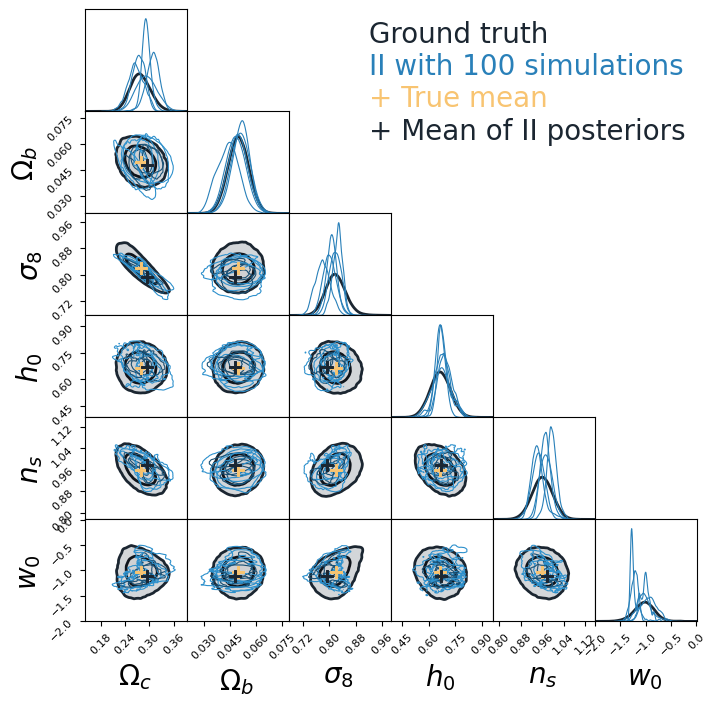

<Figure size 640x480 with 0 Axes>

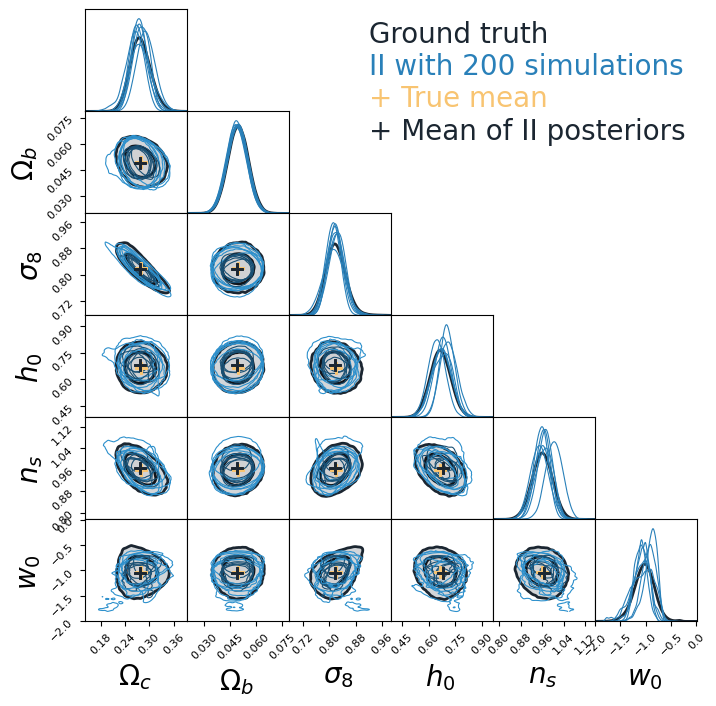

<Figure size 640x480 with 0 Axes>

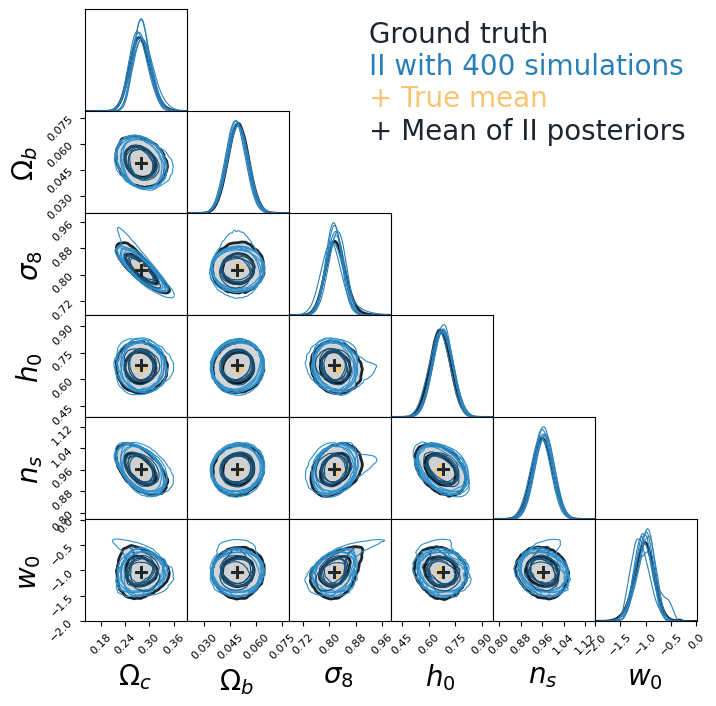

<Figure size 640x480 with 0 Axes>

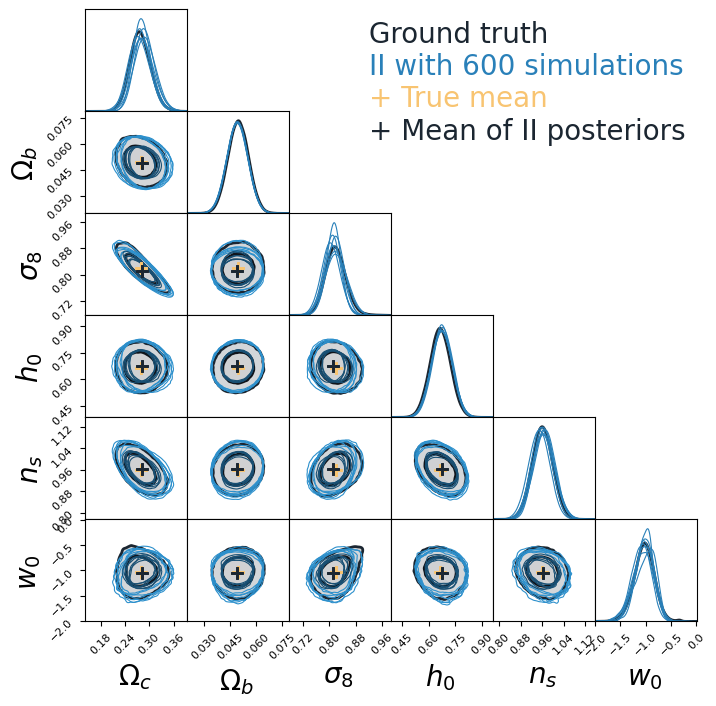

<Figure size 640x480 with 0 Axes>

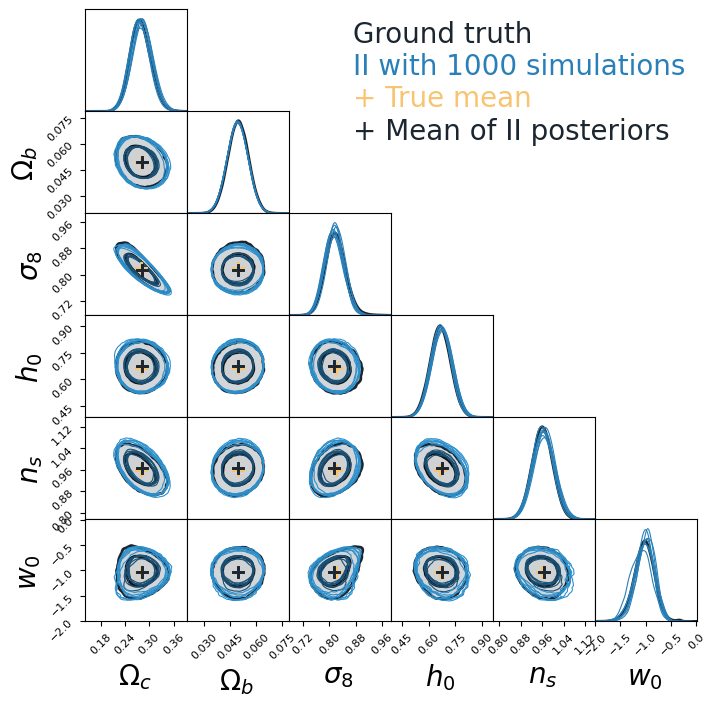

<Figure size 640x480 with 0 Axes>

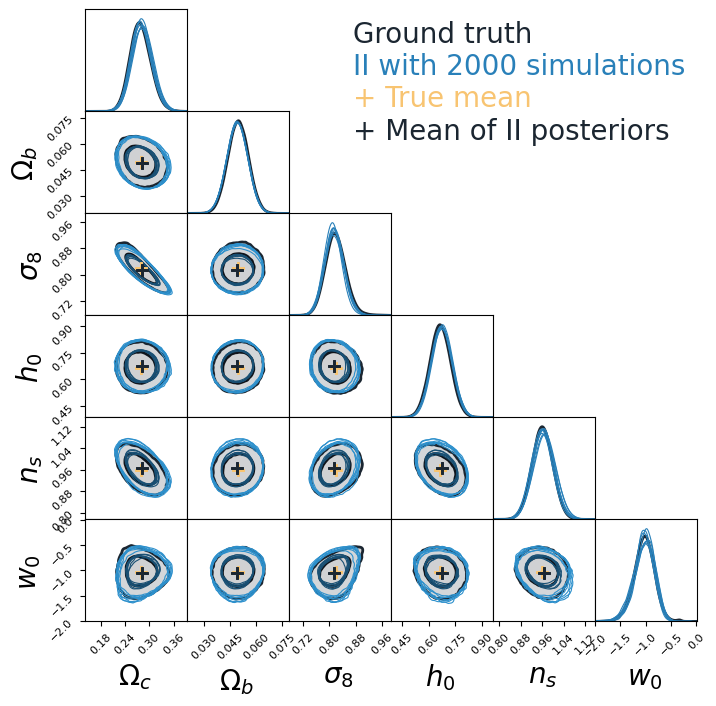

Exception ignored in atexit callback: <bound method InteractiveShell.atexit_operations of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f04a3045d80>>
Traceback (most recent call last):
  File "/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3809, in atexit_operations
    self._atexit_once()
  File "/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3792, in _atexit_once
    self.history_manager.end_session()
  File "/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/IPython/core/history.py", line 576, in end_session
    self.writeout_cache()
  File "/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/decorator.py", line 232, in fun
    return caller(func, *(extras + args), **kw)
  File "/gp

In [2]:
# import arviz as az
from chainconsumer import ChainConsumer
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sbi_lens.config import config_lsst_y_10
import numpy as np

params_name = config_lsst_y_10.params_name_latex
truth = config_lsst_y_10.truth
# az.style.use("arviz-white")

sample_ff = jnp.load(
    "/linkhome/rech/genkqu01/ufa23yn/sbi_lens/sbi_lens/data/posterior_full_field__256N_10ms_27gpa_0.26se.npy"
)
mean_truth = jnp.mean(sample_ff, axis = 0)
std_truth = jnp.std(sample_ff, axis = 0)

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams['lines.markersize'] = 7
color = [
   '#f8c471',
    '#d68910',
    '#cd6155',
    '#edbb99',
    '#5d6d7e',
    '#73c6b6',
    '#a3b899'
]

total_steps = 70_000
n_flow_layers = 4
n_bijector_layers = 2
activ_fun = 'silu'
proposal = 'prior'
sbi_method  = 'nle'
lr_schedule = 'exp_decay'
nf = 'affine'
bacth_size = 128
seed=3


info_setup = [
    ['unmarginal', 0.0, 0.0]
]

metric_mean = {}
metric_std = {}
sim = {}
for info in info_setup:

    score, score_noise, score_weight = info

    posterior_mean_mean_store = []
    posterior_mean_std_store = []
    posterior_std_mean_store = []
    posterior_std_std_store = []

    for nb_simulations_allow in [100,200,400,600,1000,2000]:
        
        posterior_mean = []
        posterior_std = []
        count = 0
        plt.figure()
        c = ChainConsumer()
        c.add_chain(
                sample_ff,
                parameters=params_name,
                name='Ground truth',
                linewidth=2,
                color = '#1B2631',
                shade_alpha = 0.2, 
                shade = True, 
                # linestyle = '--'
        )
        for seed in [1,2,3,4,5,6,111]:
            exp_id = "exp_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
                sbi_method,
                total_steps,
                nb_simulations_allow,
                seed,
                n_flow_layers,
                n_bijector_layers,
                activ_fun,
                nf,
                bacth_size,
                score_weight,
                score,
                score_noise,
            )
            posterior = np.load('../results/experiments/{}/posteriors_sample.npy'.format(exp_id))
            if posterior.size != 0:
                posterior_mean.append(posterior[:10_000])
                c.add_chain(
                        posterior,
                        parameters=params_name,
                        name=f'II with {nb_simulations_allow} simulations',
                        linewidth=0.8,
                        color = '#2980B9', #'#0E6655',
                        shade_alpha = 0.5,
                        shade = False
                )

        mean_spoterior = jnp.mean(jnp.array(posterior_mean).reshape([-1,6]), axis = 0)
        c.add_marker(jnp.array(mean_truth).squeeze(), name="+ True mean", marker_style="$+$", marker_size=80, color=color[0])
        c.add_marker(jnp.array(mean_spoterior).squeeze(), name="+ Mean of II posteriors", marker_style="$+$",  marker_size=80, color='#1B2631')
        c.configure(legend_kwargs={"fontsize": 20}, tick_font_size=8, label_font_size=20)
        fig = c.plotter.plot(
            figsize=0.8,
            extents=[[t - 5 * np.std(sample_ff[:,i]),
                      t + 5 * np.std(sample_ff[:,i])] for i,t in enumerate(truth)]
        )
        plt.savefig(f'contourplot_{nb_simulations_allow}_simu.pdf', transparent = True)